To use 'waterfront', we need to deal with substantial number of NaNs.
1. Assume NaN should be NO: This preserves rows, and simplifies explanations
2. Recode NaN as third category: This preserves rows, but doesn't make assumptions
3. Drop NaNs: I don't think we want to do this, because we'd lose **tons** of rows
We should code this so that 'NO' = 0 and 'YES' = 1

To use 'view':
- NaN can be recoded as NONE
- This appears to be an ordinal variable (none < fair < average < good < excellent). 
    - Check whether there is linear relationship between 'view' coded as ordinal.
    - Check whether 'view' as categorical explains (substantially) greater adj. R^2 than 'view' as ordinal

To use 'condition':
- This may be ordinal variable (Poor < Fair < Average < Good < Very Good)
    - Check whether there is linear relationship between 'view' coded as ordinal.
    - Check whether 'view' as categorical explains (substantially) greater adj. R^2 than 'view' as ordinal

To use 'grade':
- Again, another ordinal (but with lots of levels)
- Grades below 6 do not meet current building codes (who would buy them?)
- Consider breaking this into "low" medium and high

To use 'sqft_basement':
- Convert '?' to NaN
- Determine how to deal with so many 0's: We might want to just binarize

To use 'yr_renovated':
- Determine how to deal with so many 0's: We might want to just binarize renovated vs. not renovated

Other ideas:
- Fix 33 bedrooms: probably fat fingers typo of 3 bedrooms (drop, replace with median)
- 'year_sold': Grab last 4 characters from 'date' to get year sold
- Convert yr_built to 'age' of home at sale (using year_sold)
- Look at duplicates in 'id' variable
- "One example of feature engineering could be using the date feature to create a new feature called season, which represents whether the home was sold in Spring, Summer, Fall, or Winter."


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split

In [2]:
# Make pandas display all columns
pd.set_option('display.max_columns', None)
# Make pandas display all rows
pd.set_option('display.max_rows', None)


# print big numbers in pd.DataFrame (instead of scientific notation)
pd.set_option('display.precision', 12)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set matplotlib title font size
plt.rcParams['axes.titlesize'] = 18

## Define helper functions

In [3]:
def dataframe_info(df):
    '''
    Takes Pandas dataframe (df). Prints number of rows, number of columns, and three sample rows.
    Returns list of numerical columns and list of non-numerical columns.
    '''
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    object_cols  = df.select_dtypes(exclude=np.number).columns.tolist()

    nrows, ncol = df.shape
    nmid = nrows // 2
    
    print(f"Dimensions: {nrows} rows and {ncol} columns")
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Object columns: {len(object_cols)}")

    display(df.iloc[[0,nmid,nrows-1]])

    return numeric_cols, object_cols

In [4]:
def cleaned_column_names(column_list):
    '''
    Takes list of column names (e.g. from df.columns). 
    Returns list of cleaned column names that can be assigned to DataFrame.
    Usage: df.columns = cleaned_column_names(df.columns)
    '''
    return [name.strip().lower().replace(' ','').replace('-', '_') for name in column_list]

In [5]:
# Testing the assumptions of linear regression
# 

# EDA

In [6]:
df = pd.read_csv('../data/kc_house_data.csv')
df.columns = cleaned_column_names(df.columns)

In [7]:
## Run this cell without changes
#y = df["price"]
#X = df.drop("price", axis=1)

In [8]:
#    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Determine numeric vs. categorical features and find NaNs

In [9]:
#y_train.isna().sum()

In [10]:
#y_test.isna().sum()

In [11]:
numeric_cols, object_cols = dataframe_info(df)

Dimensions: 21597 rows and 21 columns
Numeric columns: 15
Object columns: 6


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,NaN,NONE,Average,7 Average,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
10798,2337300370,2/6/2015,175000.00,3,1.00,1030,8395,1.00,NO,NONE,Good,7 Average,1030,0.0,1960,0.00,98023,47.33,-122.34,1370,9380
21596,1523300157,10/15/2014,325000.00,2,0.75,1020,1076,2.00,NO,NONE,Average,7 Average,1020,0.0,2008,0.00,98144,47.59,-122.30,1020,1357


In [12]:
df[numeric_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   sqft_above     21597 non-null  int64  
 8   yr_built       21597 non-null  int64  
 9   yr_renovated   17755 non-null  float64
 10  zipcode        21597 non-null  int64  
 11  lat            21597 non-null  float64
 12  long           21597 non-null  float64
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 2.5 MB


- [ ] Deal with NaN values in `yr_renovated` column

In [13]:
df[object_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           21597 non-null  object
 1   waterfront     19221 non-null  object
 2   view           21534 non-null  object
 3   condition      21597 non-null  object
 4   grade          21597 non-null  object
 5   sqft_basement  21597 non-null  object
dtypes: object(6)
memory usage: 1012.5+ KB


- [ ] Deal with NaN values in `waterfront` column
- [ ] Deal with NaN values in `view` column
- [ ] Convert `sqft_basement` to numeric column

## Check for duplicate `id` records and decide how to handle

In [14]:
print(f"Number of rows:\t\t{len(df['id'])}")
print(f"Number unique:\t\t{len(df['id'].unique())}")
print(f"Number duplicates:\t{sum(df['id'].duplicated() == True)}")

Number of rows:		21597
Number unique:		21420
Number duplicates:	177


It appears that `id` has duplicated values. Let's see what the duplicates contain.
- Are these multiple sales of the same house?
- Are there changes to columns other than date and price?

In [15]:
dup_filt = df['id'].duplicated(keep=False)==True
df[dup_filt].sort_values(by=['id']).head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,4/22/2015,300000.00,6,3.00,2400,9373,2.00,NO,NONE,Average,7 Average,2400,0.0,1991,0.00,98002,47.33,-122.21,2060,7316
2494,1000102,9/16/2014,280000.00,6,3.00,2400,9373,2.00,NaN,NONE,Average,7 Average,2400,0.0,1991,0.00,98002,47.33,-122.21,2060,7316
16800,7200179,10/16/2014,150000.00,2,1.00,840,12750,1.00,NO,NONE,Average,6 Low Average,840,0.0,1925,0.00,98055,47.48,-122.21,1480,6969
16801,7200179,4/24/2015,175000.00,2,1.00,840,12750,1.00,NO,NONE,Average,6 Low Average,840,0.0,1925,nan,98055,47.48,-122.21,1480,6969
11422,109200390,10/20/2014,250000.00,3,1.75,1480,3900,1.00,NO,NONE,Good,7 Average,1480,0.0,1980,0.00,98023,47.30,-122.37,1830,6956
11421,109200390,8/20/2014,245000.00,3,1.75,1480,3900,1.00,NO,NONE,Good,7 Average,1480,0.0,1980,0.00,98023,47.30,-122.37,1830,6956
12406,123039336,12/8/2014,244900.00,1,1.00,620,8261,1.00,NO,NONE,Average,5 Fair,620,0.0,1939,nan,98106,47.51,-122.36,1180,8244
12405,123039336,6/11/2014,148000.00,1,1.00,620,8261,1.00,NO,NONE,Average,5 Fair,620,0.0,1939,0.00,98106,47.51,-122.36,1180,8244
7786,251300110,1/14/2015,358000.00,3,2.25,2510,12013,2.00,NO,NONE,Average,8 Good,2510,0.0,1988,0.00,98003,47.35,-122.31,1870,8017
7785,251300110,7/31/2014,225000.00,3,2.25,2510,12013,2.00,NO,NONE,Average,8 Good,2510,0.0,1988,0.00,98003,47.35,-122.31,1870,8017


It appears that these duplicates are multiple sales of the same house.
- `date` changes but other columns don't, suggesting these are separate sales of the same house
- Occasionally, `waterfront`, `yr_renovated`, and `sqft_basement` change, because of missing / mistyped information
- `yr_renovated` column doesn't change for 'flipped' houses

In [16]:
# I'm sure I could test every column for dups using .apply or list comp, but can't think of it right now
exact_match = df[dup_filt].drop(['date', 'waterfront', 'yr_renovated', 'sqft_basement'], axis=1).duplicated(keep=False)
#df.loc[dup_filt].loc[ ~ exact_match ]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,430000.00,3,1.50,1580,5000,1.00,NO,NONE,Average,8 Good,1290,290.0,1939,0.00,98117,47.69,-122.39,1570,4500
94,6021501535,12/23/2014,700000.00,3,1.50,1580,5000,1.00,NO,NONE,Average,8 Good,1290,290.0,1939,0.00,98117,47.69,-122.39,1570,4500
313,4139480200,6/18/2014,1380000.00,4,3.25,4290,12103,1.00,NO,GOOD,Average,11 Excellent,2690,1600.0,1997,0.00,98006,47.55,-122.10,3860,11244
314,4139480200,12/9/2014,1400000.00,4,3.25,4290,12103,1.00,NO,GOOD,Average,11 Excellent,2690,1600.0,1997,0.00,98006,47.55,-122.10,3860,11244
324,7520000520,9/5/2014,232000.00,2,1.00,1240,12092,1.00,NaN,NONE,Average,6 Low Average,960,280.0,1922,1984.00,98146,47.50,-122.35,1820,7460
325,7520000520,3/11/2015,240500.00,2,1.00,1240,12092,1.00,NO,NONE,Average,6 Low Average,960,280.0,1922,1984.00,98146,47.50,-122.35,1820,7460
345,3969300030,7/23/2014,165000.00,4,1.00,1000,7134,1.00,NO,NONE,Average,6 Low Average,1000,0.0,1943,0.00,98178,47.49,-122.24,1020,7138
346,3969300030,12/29/2014,239900.00,4,1.00,1000,7134,1.00,NO,NONE,Average,6 Low Average,1000,0.0,1943,nan,98178,47.49,-122.24,1020,7138
371,2231500030,10/1/2014,315000.00,4,2.25,2180,10754,1.00,NaN,NONE,Very Good,7 Average,1100,1080.0,1954,0.00,98133,47.77,-122.34,1810,6929
372,2231500030,3/24/2015,530000.00,4,2.25,2180,10754,1.00,NO,NONE,Very Good,7 Average,1100,1080.0,1954,0.00,98133,47.77,-122.34,1810,6929


In [17]:
remove_dup_filt = df['id'].duplicated('first')==True
remove_dup_filt.sum()

177

To use 'waterfront', we need to deal with substantial number of NaNs.
1. Assume NaN should be NO: This preserves rows, and simplifies explanations
2. Recode NaN as third category: This preserves rows, but doesn't make assumptions
3. Drop NaNs: I don't think we want to do this, because we'd lose **tons** of rows
We should code this so that 'NO' = 0 and 'YES' = 1

In [18]:
df['waterfront'].value_counts(dropna=False)

NO     19075
NaN     2376
YES      146
Name: waterfront, dtype: int64

To use 'view':
- NaN can be recoded as NONE
- This appears to be an ordinal variable (none < fair < average < good < excellent). 
    - Check whether there is linear relationship between 'view' coded as ordinal.
    - Check whether 'view' as categorical explains (substantially) greater adj. R^2 than 'view' as ordinal

In [19]:
df['view'].value_counts(dropna=False)

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
NaN             63
Name: view, dtype: int64

To use 'condition':
- This may be ordinal variable (Poor < Fair < Average < Good < Very Good)
    - Check whether there is linear relationship between 'view' coded as ordinal.
    - Check whether 'view' as categorical explains (substantially) greater adj. R^2 than 'view' as ordinal

In [20]:
df['condition'].value_counts(dropna=False)

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

To use 'grade':
- Grades below 6 do not meet current building codes (who would buy them?)

In [21]:
df['grade'].value_counts(dropna=False)

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [22]:
df['grade_number'] = df['grade'].str.split() # converting grade to only contain the number.  
                                                #Split the number and word by the space
df['grade_number'] = [int(x[0]) for x in df['grade_number']] #list comprehension to only take the first element

To use 'sqft_basement':
- Convert '?' to NaN
- Determine how to deal with so many 0's: We might want to just binarize 

In [23]:
sqft_basement_float = pd.to_numeric(df['sqft_basement'], errors='coerce')
filt = sqft_basement_float.isna()
df['sqft_basement'][filt].value_counts()

?    454
Name: sqft_basement, dtype: int64

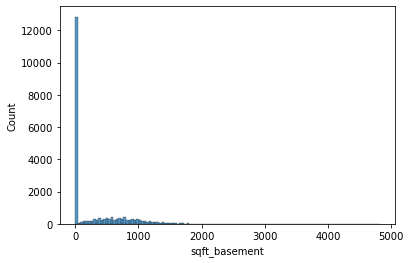

In [24]:
sns.histplot(sqft_basement_float);

In [25]:
(sqft_basement_float == 0).sum()

12826

To use 'yr_renovated':
- Determine how to deal with so many 0's: We might want to just binarize renovated vs. not renovated

In [26]:
df['yr_renovated'].describe()

count   17755.00
mean       83.64
std       399.95
min         0.00
25%         0.00
50%         0.00
75%         0.00
max      2015.00
Name: yr_renovated, dtype: float64

In [27]:
(df['yr_renovated'] == 0).sum()

17011

In [28]:
(df['yr_renovated'].isna()).sum()

3842

In [29]:
df[ df['yr_renovated'] > 0 ]['yr_renovated'].describe()

count    744.00
mean    1995.93
std       15.60
min     1934.00
25%     1987.00
50%     2000.00
75%     2007.25
max     2015.00
Name: yr_renovated, dtype: float64

In [30]:
df['renovated'] = [1 if x > 0 else 0 for x in df['yr_renovated']]

In [31]:
df['renovated'].sum()

744

In [32]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_number,renovated
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28,7.66,0.03
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44,1.17,0.18
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,3.00,0.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00,7.00,0.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00,7.00,0.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00,8.00,0.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00,13.00,1.00


In [33]:
df.corr()['price']

id              -0.02
price            1.00
bedrooms         0.31
bathrooms        0.53
sqft_living      0.70
sqft_lot         0.09
floors           0.26
sqft_above       0.61
yr_built         0.05
yr_renovated     0.13
zipcode         -0.05
lat              0.31
long             0.02
sqft_living15    0.59
sqft_lot15       0.08
grade_number     0.67
renovated        0.12
Name: price, dtype: float64

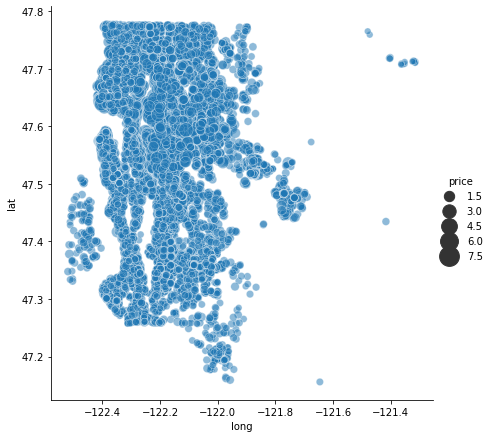

In [34]:
sns.relplot(x="long", y="lat", size='price',
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df);

#sns.relplot(x="long", y="lat", size="price",
#            sizes=(40, 400), alpha=.5, palette="muted",
#            height=6, data=df)

In [35]:
first_model_df = df[['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'bedrooms', 'bathrooms']].copy()
first_model_df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], errors='coerce')

In [36]:
y = first_model_df['price']
X = first_model_df.drop(columns='price')

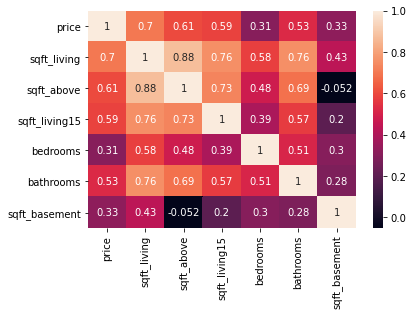

In [37]:
sns.heatmap(first_model_df.corr(), annot=True);
#sns.heatmap(first_model_df[outlier_filter].corr(), annot=True);

Observations from heatmap:
- multicollinearlity among 'sqft_living', 'sqft_above', 'sqft_living15', and 'bathrooms'

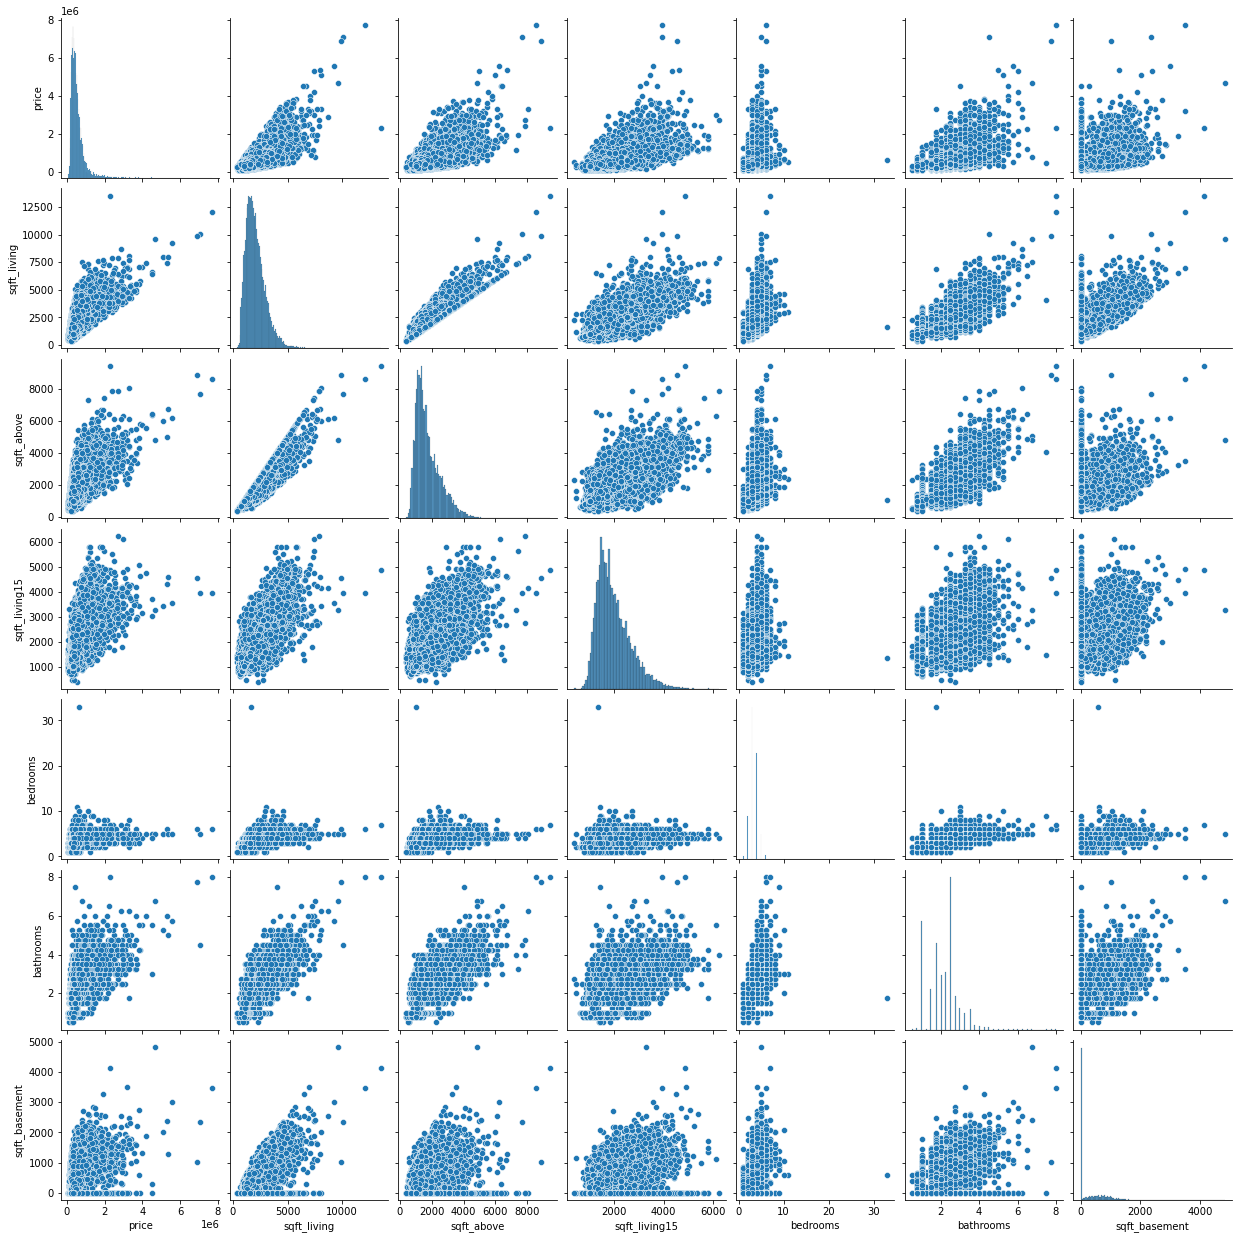

In [38]:
sns.pairplot(first_model_df);

Observations from pairplot:
- price:
    - distribution is right-skewed
    - outlier high price houses will weight several correlations
    - 'bedrooms' outlier may be pulling down correlation with 'price'
- sqft_living:
    - distribution is right-skewed
    - outlier values may pull regression line with 'price' upwards
    - scatterplot with 'sqft_above' has many observations on straight line (houses without basements). We might want to look at houses with basements vs. without basements separately (or as interaction)

In [39]:
formula = 'price ~ sqft_living'
first_mod = ols(formula, first_model_df).fit()
first_mod_summary = first_mod.summary()
first_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:50:56   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
df['yr_renovated'].describe()

count   17755.00
mean       83.64
std       399.95
min         0.00
25%         0.00
50%         0.00
75%         0.00
max      2015.00
Name: yr_renovated, dtype: float64

In [41]:
sum(df['yr_renovated'] > 0)

744

In [42]:
df['renovated'] = [1 if x > 2010 else 0 for x in df['yr_renovated']]

In [43]:
second_model_df = df[['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'bedrooms', 'bathrooms', 'renovated']].copy()
second_model_df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], errors='coerce')

In [44]:
formula = 'price ~ sqft_living + renovated'
second_mod = ols(formula, second_model_df).fit()
second_mod_summary = second_mod.summary()
second_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 1.051e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:50:56   Log-Likelihood:            -3.0005e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.459e+04   4409.567    -10.111      0.000   -5.32e+04   -3.59e+04
sqft_living   280.8259      1.938    144.872      0.000     277.026     284.625
renovated    1.079e+05   2.26e+04      4.779      0.000    6.36e+04    1.52e+05
==============================================================================
Omnibus:                    14821.926   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           545790.818
Skew:                           2.824   Prob(JB):                         0.00
Kurtosis:                      26.971   Cond. No.                     2.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
second_mod.params

Intercept     -44586.20
sqft_living      280.83
renovated     107905.30
dtype: float64

In [46]:
second_model_df['renovated'].sum()

135

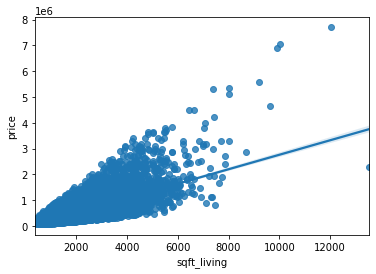

In [47]:
sns.regplot(x="sqft_living", y="price", label='renovated', data=df);

In [48]:
df['condition'].value_counts(dropna=False)

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [49]:
from sklearn.preprocessing import OneHotEncoder

ohe_condition = OneHotEncoder(handle_unknown='ignore', sparse=False)
conditions = pd.DataFrame(ohe_condition.fit_transform(df[['condition']]))

In [50]:
conditions.columns = cleaned_column_names(["condition_" + x for x in list(ohe_condition.categories_[0])])
dataframe_info(conditions)

Dimensions: 21597 rows and 5 columns
Numeric columns: 5
Object columns: 0


,condition_average,condition_fair,condition_good,condition_poor,condition_verygood
0,1.00,0.00,0.00,0.00,0.00
10798,0.00,0.00,1.00,0.00,0.00
21596,1.00,0.00,0.00,0.00,0.00


(['condition_average',
  'condition_fair',
  'condition_good',
  'condition_poor',
  'condition_verygood'],
 [])

In [51]:
df['condition_ordinal'] = conditions['condition_fair'] + (conditions['condition_average'] * 2) + (conditions['condition_good'] * 3) + (conditions['condition_verygood'] * 4)

In [52]:
df['condition_ordinal'].value_counts(dropna=False)

2.00    14020
3.00     5677
4.00     1701
1.00      170
0.00       29
Name: condition_ordinal, dtype: int64

In [53]:
df['grade'].value_counts(dropna=False)

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [54]:
ohe_grade = OneHotEncoder(handle_unknown='ignore', sparse=False)
grades = pd.DataFrame(ohe_grade.fit_transform(df[['grade']]))
grades.columns = cleaned_column_names(["grade_" + x for x in list(ohe_grade.categories_[0])])
dataframe_info(grades)

Dimensions: 21597 rows and 11 columns
Numeric columns: 11
Object columns: 0


,grade_10verygood,grade_11excellent,grade_12luxury,grade_13mansion,grade_3poor,grade_4low,grade_5fair,grade_6lowaverage,grade_7average,grade_8good,grade_9better
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
10798,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
21596,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


(['grade_10verygood',
  'grade_11excellent',
  'grade_12luxury',
  'grade_13mansion',
  'grade_3poor',
  'grade_4low',
  'grade_5fair',
  'grade_6lowaverage',
  'grade_7average',
  'grade_8good',
  'grade_9better'],
 [])

In [55]:
df['grade_ordinal'] = (grades['grade_3poor'] * 3) + (grades['grade_4low'] * 4) + (grades['grade_5fair'] * 5) + (grades['grade_6lowaverage'] * 6) + (grades['grade_7average'] * 7) + (grades['grade_8good'] * 8) + (grades['grade_9better'] * 9) + (grades['grade_10verygood'] * 10) + (grades['grade_11excellent'] * 11) + (grades['grade_12luxury'] * 12) + (grades['grade_13mansion'] * 13)

<AxesSubplot:>

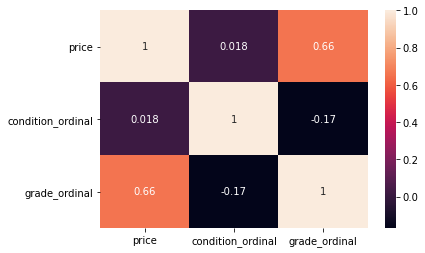

In [56]:
ordinal_df = df[['price', 'condition_ordinal', 'grade_ordinal']].copy()
sns.heatmap(ordinal_df.corr(method='spearman'), annot=True)

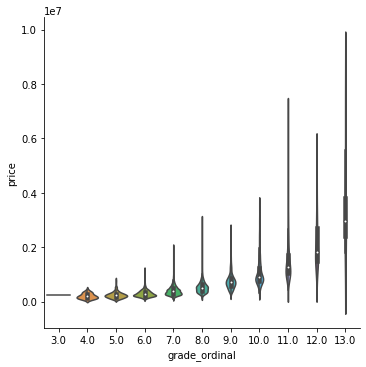

In [57]:
sns.catplot(x='grade_ordinal', y='price', kind='violin', data=df);

In [58]:
df['price'].describe()

count     21597.00
mean     540296.57
std      367368.14
min       78000.00
25%      322000.00
50%      450000.00
75%      645000.00
max     7700000.00
Name: price, dtype: float64

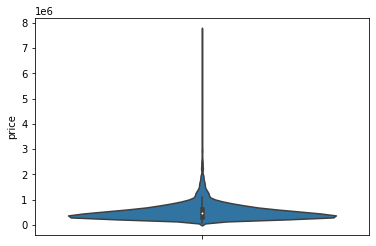

In [59]:
sns.violinplot(y=df['price']);

In [60]:
def outliers_IQR(series):
    '''
    Takes a series of values. Returns lower threshold (1.5 IQR below median) and higher threshold (1.5 IQR above median),
    and a series of boolean values to **retain** (True = value is between thresholds, False = value is outside of thresholds).
    '''
    Q3 = np.quantile(series, 0.75)
    Q1 = np.quantile(series, 0.25)
    IQR = Q3 - Q1
 
    low_threshold   = Q1 - (1.5 * IQR)
    high_threshold  = Q3 + (1.5 * IQR)
    outlier_filter = ((series >= low_threshold) & (series <= high_threshold))
    return low_threshold, high_threshold, outlier_filter

In [61]:
low_threshold, high_threshold, outlier_filter = outliers_IQR(df['price'])
print(f"Values below {low_threshold} or above {high_threshold} are outliers.")
print(f"There were {sum( ~ outlier_filter )} outliers, out of {len(outlier_filter)} rows")

Values below -162500.0 or above 1129500.0 are outliers.
There were 1158 outliers, out of 21597 rows


<AxesSubplot:>

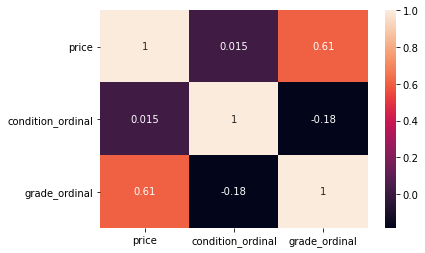

In [62]:
ordinal_df = df[['price', 'condition_ordinal', 'grade_ordinal']].copy()
sns.heatmap(ordinal_df[outlier_filter].corr(method='spearman'), annot=True)

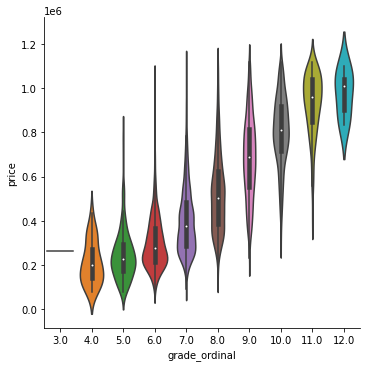

In [63]:
sns.catplot(x='grade_ordinal', y='price', kind='violin', data=df[outlier_filter]);

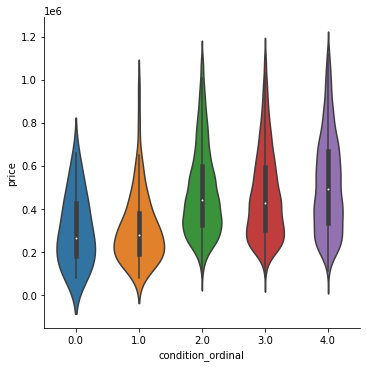

In [64]:
sns.catplot(x='condition_ordinal', y='price', kind='violin', data=df[outlier_filter]);

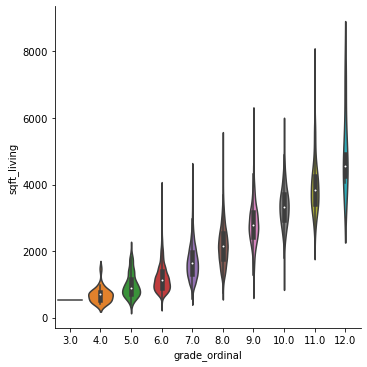

In [65]:
sns.catplot(x='grade_ordinal', y='sqft_living', kind='violin', data=df[outlier_filter]);

In [66]:
formula = 'price ~ sqft_living'
first_mod_no_outliers = ols(formula, df[outlier_filter]).fit()
first_mod_no_outliers_summary = first_mod_no_outliers.summary()
first_mod_no_outliers_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 1.285e+04
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:51:00   Log-Likelihood:            -2.7428e+05
No. Observations:               20439   AIC:                         5.486e+05
Df Residuals:                   20437   BIC:                         5.486e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.471e+05   3122.142     47.125      0.000    1.41e+05    1.53e+05
sqft_living   166.8563      1.472    113.371      0.000     163.971     169.741
==============================================================================
Omnibus:                      917.003   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1043.823
Skew:                           0.543   Prob(JB):                    2.17e-227
Kurtosis:                       3.215   Cond. No.                     5.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
formula = 'price ~ sqft_living + renovated'
second_mod_no_outliers = ols(formula, df[outlier_filter]).fit()
second_mod_no_outliers_summary = second_mod_no_outliers.summary()
second_mod_no_outliers_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     6471.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:51:00   Log-Likelihood:            -2.7425e+05
No. Observations:               20439   AIC:                         5.485e+05
Df Residuals:                   20436   BIC:                         5.485e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.466e+05   3118.917     46.999      0.000     1.4e+05    1.53e+05
sqft_living   166.7982      1.470    113.479      0.000     163.917     169.679
renovated    1.079e+05   1.46e+04      7.398      0.000    7.93e+04    1.37e+05
==============================================================================
Omnibus:                      903.681   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1026.776
Skew:                           0.539   Prob(JB):                    1.09e-223
Kurtosis:                       3.213   Cond. No.                     2.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
second_mod_no_outliers.params

Intercept     146584.49
sqft_living      166.80
renovated     107923.78
dtype: float64

In [69]:
grades[outlier_filter].describe()

,grade_10verygood,grade_11excellent,grade_12luxury,grade_13mansion,grade_3poor,grade_4low,grade_5fair,grade_6lowaverage,grade_7average,grade_8good,grade_9better
count,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00
mean,0.04,0.01,0.00,0.00,0.00,0.00,0.01,0.10,0.44,0.29,0.11
std,0.19,0.08,0.02,0.00,0.01,0.04,0.11,0.30,0.50,0.45,0.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
max,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [70]:
model_df = pd.concat([df, grades], axis=1)

In [71]:
model_df[outlier_filter].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_number,renovated,condition_ordinal,grade_ordinal,grade_10verygood,grade_11excellent,grade_12luxury,grade_13mansion,grade_3poor,grade_4low,grade_5fair,grade_6lowaverage,grade_7average,grade_8good,grade_9better
count,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,16812.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00,20439.00
mean,4603264120.62,476702.63,3.33,2.05,1975.19,14585.57,1.48,1708.12,1970.81,74.18,98078.58,47.56,-122.21,1921.94,12427.84,7.53,0.01,2.41,7.53,0.04,0.01,0.00,0.00,0.00,0.00,0.01,0.10,0.44,0.29,0.11
std,2877522881.31,207790.28,0.91,0.71,773.80,40009.82,0.54,726.91,29.16,377.56,53.35,0.14,0.14,614.55,26469.43,1.04,0.08,0.65,1.04,0.19,0.08,0.02,0.00,0.01,0.04,0.11,0.30,0.50,0.45,0.32
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,3.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2131450912.50,315000.00,3.00,1.50,1400.00,5000.00,1.00,1170.00,1951.00,0.00,98033.00,47.46,-122.33,1470.00,5046.00,7.00,0.00,2.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3905081350.00,437500.00,3.00,2.00,1860.00,7500.00,1.00,1520.00,1974.00,0.00,98065.00,47.57,-122.23,1800.00,7542.00,7.00,0.00,2.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,7338200175.00,600000.00,4.00,2.50,2430.00,10316.50,2.00,2100.00,1996.00,0.00,98118.00,47.68,-122.12,2280.00,9880.00,8.00,0.00,3.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
max,9900000190.00,1120000.00,33.00,7.50,7480.00,1651359.00,3.50,5710.00,2015.00,2015.00,98199.00,47.78,-121.31,5380.00,871200.00,12.00,1.00,4.00,12.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [72]:
formula =  'price ~ sqft_living + renovated + \
            grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + \
            grade_9better + grade_10verygood + grade_11excellent + grade_12luxury'#  + grade_13mansion'
third_mod_no_outliers = ols(formula, model_df[outlier_filter]).fit()
third_mod_no_outliers_summary = third_mod_no_outliers.summary()
third_mod_no_outliers_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     1622.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:51:01   Log-Likelihood:            -2.7285e+05
No. Observations:               20439   AIC:                         5.457e+05
Df Residuals:                   20427   BIC:                         5.458e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.455e+05   3659.142     67.099      0.000    2.38e+05    2.53e+05
sqft_living          91.7980      1.948     47.119      0.000      87.979      95.617
renovated          1.205e+05   1.36e+04      8.844      0.000    9.38e+04    1.47e+05
grade_3poor       -3.126e+04   1.52e+05     -0.206      0.837   -3.29e+05    2.66e+05
grade_4low        -9.601e+04   2.93e+04     -3.273      0.001   -1.54e+05   -3.85e+04
grade_5fair       -8.777e+04   9987.629     -8.788      0.000   -1.07e+05   -6.82e+04
grade_6lowaverage -5.413e+04   3851.129    -14.055      0.000   -6.17e+04   -4.66e+04
grade_8good        7.985e+04   2708.769     29.478      0.000    7.45e+04    8.52e+04
grade_9better      1.824e+05   4161.122     43.845      0.000    1.74e+05    1.91e+05
grade_10verygood   2.545e+05   6572.775     38.722      0.000    2.42e+05    2.67e+05
grade_11excellent  3.223e+05   1.38e+04     23.359      0.000    2.95e+05    3.49e+05
grade_12luxury     2.736e+05   6.82e+04      4.009      0.000     1.4e+05    4.07e+05
==============================================================================
Omnibus:                     1278.545   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1571.952
Skew:                           0.618   Prob(JB):                         0.00
Kurtosis:                       3.562   Cond. No.                     3.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
third_mod_no_outliers.params

Intercept           245525.87
sqft_living             91.80
renovated           120528.69
grade_3poor         -31260.81
grade_4low          -96014.64
grade_5fair         -87767.33
grade_6lowaverage   -54126.53
grade_8good          79848.67
grade_9better       182445.05
grade_10verygood    254512.32
grade_11excellent   322279.11
grade_12luxury      273585.83
dtype: float64

In [74]:
formula =  'price ~ renovated + \
            grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + \
            grade_9better + grade_10verygood + grade_11excellent + grade_12luxury'#  + grade_13mansion'
third_mod_no_outliers_check = ols(formula, model_df[outlier_filter]).fit()
third_mod_no_outliers_check_summary = third_mod_no_outliers_check.summary()
third_mod_no_outliers_check_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     1409.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:51:01   Log-Likelihood:            -2.7390e+05
No. Observations:               20439   AIC:                         5.478e+05
Df Residuals:                   20428   BIC:                         5.479e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.004e+05   1691.389    236.752      0.000    3.97e+05    4.04e+05
renovated          1.307e+05   1.43e+04      9.109      0.000    1.03e+05    1.59e+05
grade_3poor       -1.384e+05    1.6e+05     -0.866      0.387   -4.52e+05    1.75e+05
grade_4low        -1.884e+05   3.08e+04     -6.114      0.000   -2.49e+05   -1.28e+05
grade_5fair       -1.525e+05   1.04e+04    -14.636      0.000   -1.73e+05   -1.32e+05
grade_6lowaverage -9.973e+04   3924.768    -25.411      0.000   -1.07e+05    -9.2e+04
grade_8good        1.241e+05   2674.864     46.411      0.000    1.19e+05    1.29e+05
grade_9better      2.856e+05   3725.266     76.679      0.000    2.78e+05    2.93e+05
grade_10verygood   4.073e+05   6019.745     67.662      0.000    3.96e+05    4.19e+05
grade_11excellent  5.301e+05   1.38e+04     38.508      0.000    5.03e+05    5.57e+05
grade_12luxury     5.766e+05   7.15e+04      8.061      0.000    4.36e+05    7.17e+05
==============================================================================
Omnibus:                     1468.297   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1850.587
Skew:                           0.671   Prob(JB):                         0.00
Kurtosis:                       3.609   Cond. No.                         152.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
third_mod_no_outliers_check.params

Intercept            400439.05
renovated            130695.04
grade_3poor         -138439.05
grade_4low          -188437.20
grade_5fair         -152455.14
grade_6lowaverage    -99733.29
grade_8good          124141.98
grade_9better        285648.23
grade_10verygood     407305.11
grade_11excellent    530065.76
grade_12luxury       576560.95
dtype: float64

In [76]:
#https://www.statology.org/how-to-calculate-vif-in-python/

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

formula =  'price ~ sqft_living + renovated + \
            grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + \
            grade_9better + grade_10verygood + grade_11excellent + grade_12luxury'#  + grade_13mansion'

# the independent variables set
y, X = dmatrices(formula, data=model_df[outlier_filter], return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,11.87
1,sqft_living,2.01
2,renovated,1.00
3,grade_3poor,1.00
4,grade_4low,1.01
5,grade_5fair,1.03
6,grade_6lowaverage,1.18
7,grade_8good,1.34
8,grade_9better,1.54
9,grade_10verygood,1.38


In [77]:
formula =  'price ~ sqft_living * renovated + \
            grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + \
            grade_9better + grade_10verygood + grade_11excellent + grade_12luxury'#  + grade_13mansion'
fourth_mod_no_outliers = ols(formula, model_df[outlier_filter]).fit()
fourth_mod_no_outliers_summary = fourth_mod_no_outliers.summary()
fourth_mod_no_outliers_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     1487.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:51:01   Log-Likelihood:            -2.7284e+05
No. Observations:               20439   AIC:                         5.457e+05
Df Residuals:                   20426   BIC:                         5.458e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.462e+05   3670.008     67.072      0.000    2.39e+05    2.53e+05
sqft_living              91.4565      1.954     46.800      0.000      87.626      95.287
renovated              3.993e+04   3.91e+04      1.022      0.307   -3.67e+04    1.17e+05
sqft_living:renovated    39.7654     18.075      2.200      0.028       4.337      75.194
grade_3poor           -3.171e+04   1.52e+05     -0.209      0.835   -3.29e+05    2.66e+05
grade_4low            -9.641e+04   2.93e+04     -3.287      0.001   -1.54e+05   -3.89e+04
grade_5fair           -8.796e+04   9987.084     -8.808      0.000   -1.08e+05   -6.84e+04
grade_6lowaverage     -5.421e+04   3850.949    -14.077      0.000   -6.18e+04   -4.67e+04
grade_8good            7.988e+04   2708.549     29.491      0.000    7.46e+04    8.52e+04
grade_9better          1.826e+05   4161.634     43.886      0.000    1.74e+05    1.91e+05
grade_10verygood        2.55e+05   6576.311     38.780      0.000    2.42e+05    2.68e+05
grade_11excellent       3.23e+05   1.38e+04     23.406      0.000    2.96e+05     3.5e+05
grade_12luxury         2.747e+05   6.82e+04      4.025      0.000    1.41e+05    4.08e+05
==============================================================================
Omnibus:                     1279.727   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1573.946
Skew:                           0.619   Prob(JB):                         0.00
Kurtosis:                       3.563   Cond. No.                     3.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
fourth_mod_no_outliers.params

Intercept               246156.45
sqft_living                 91.46
renovated                39931.15
sqft_living:renovated       39.77
grade_3poor             -31713.83
grade_4low              -96412.76
grade_5fair             -87962.40
grade_6lowaverage       -54208.70
grade_8good              79878.71
grade_9better           182635.79
grade_10verygood        255026.41
grade_11excellent       322997.78
grade_12luxury          274658.60
dtype: float64

### Check regression assumptions

1. Linear relationship between price and predictors

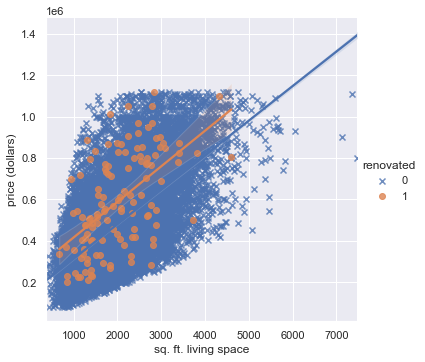

In [79]:
sns.set_theme(color_codes=True)
g = sns.lmplot(data=model_df[outlier_filter], 
               x="sqft_living", 
               y="price", 
               hue="renovated", 
               height=5,
               markers=["x", "o"])
g.set_axis_labels("sq. ft. living space", "price (dollars)");